# **Avance 2. Series de tiempo univariadas:**
## **Universidad Nacional de Colombia.**
## **Docente:**

  - [Sergio Alejandro Calderón Villanueva](sacalderonv@unal.edu.co)

## **Autores:**

  - [Michel Mendivenson Barragán Zabala](mbarraganz@unal.edu.co)
  - [Sharon Juliana Zambrano Ortiz](shzambranoo@unal.edu.co)
  - [Nicolás Alejandro Quenguan Parra](naquenguanp@unal.edu.co)
  - [Aryin Jair Torres Quiñone](artorresq@unal.edu.co)

---
**Nota 1:** Los avances estaban siendo realizados en archivos de Rmarkdown `.Rmd`. Sin embargo, como la intención de este avance es incluir algunos modelos de aprendizaje profundo (Redes neuronales multicapa y redes recurrentes) con el fin de no utilizar recursos de computo de los equipos de cada uno de los autores se entregará el avance 2 como un archivo de jupyter notebook `.ipynb` que además de permitir el uso de computación en la nube para tareas pesadas usando Google Collab cuando los recursos de forma local sean reducidos también (Por ser `python`) permite construir chunks que usen código de `R` y `python` cuyos objetos tienen la posibilidad de interactuar entre sí (Veáse: [R and Python in one Jupyter notebook](https://stackoverflow.com/questions/39008069/r-and-python-in-one-jupyter-notebook))

**Nota 2:** Si se está editando este documento desde Google Collab, no es posible hacer `commit` directamente al repositorio. En cambio, hay que dar en la opción `File > Save a copy in GitHub`.

---

En este avance, se encuentra lo correpondiente a la implementación de árboles de decisión, filtro exponencial y redes neuronales para las dos series escogidas para el desarrollo del curso:

In [176]:
# Este módulo es usado para correr código de R y hacer que los objetos de R interactuén con python
%load_ext rpy2.ipython

# Manejo de datos en general
import pandas as pd
import numpy as np

# Para poder graficar
import matplotlib.pyplot as plot

# Construcción del árbol de decisión
from sklearn.tree import DecisionTreeRegressor

# Tuning del árbol
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Medidas de precisión
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Para el ajuste de hiperparámetros
from skforecast.model_selection import grid_search_forecaster

# Para mostrar la estructura del árbol
from sklearn.tree import plot_tree

# Para gráficos de autocorrelación y autocorrelación parcial
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Para que no aparezcan alertas
import warnings
warnings.filterwarnings('ignore')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# **Volumen de acopio nacional de leche (Frecuencia mensual)** 🐮

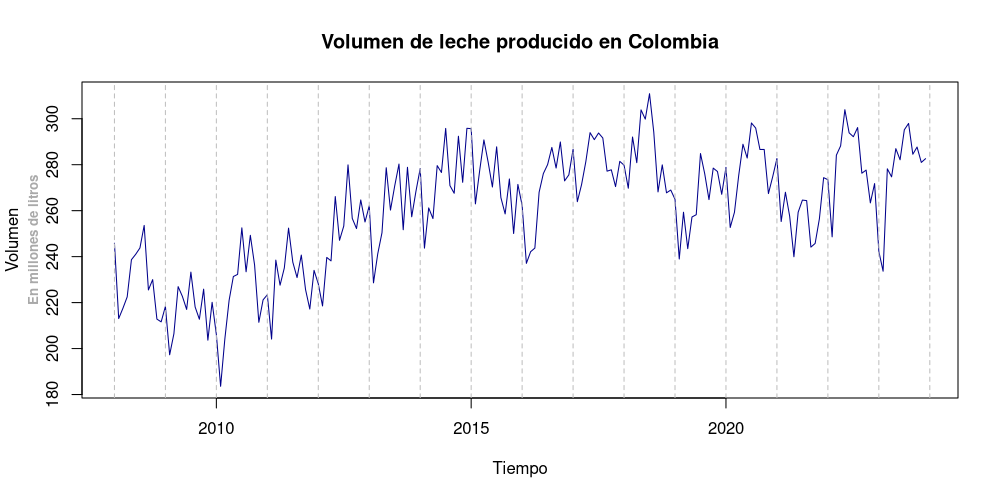

In [177]:
%%R -o leche -w 10 -h 5 --units in -r 100
Ruta = '/home/mendivenson/Documents/GitHub/Time_series/' # Cambie esta ruta a la que corresponda
source(paste0(Ruta,'Script análisis/Leche: Lectura de datos.R'))
abline(v = 2008:2024, col = 'gray', lty = 'dashed')

# **Precio del oro en Colombia (Frecuencia diaria) 🥇**

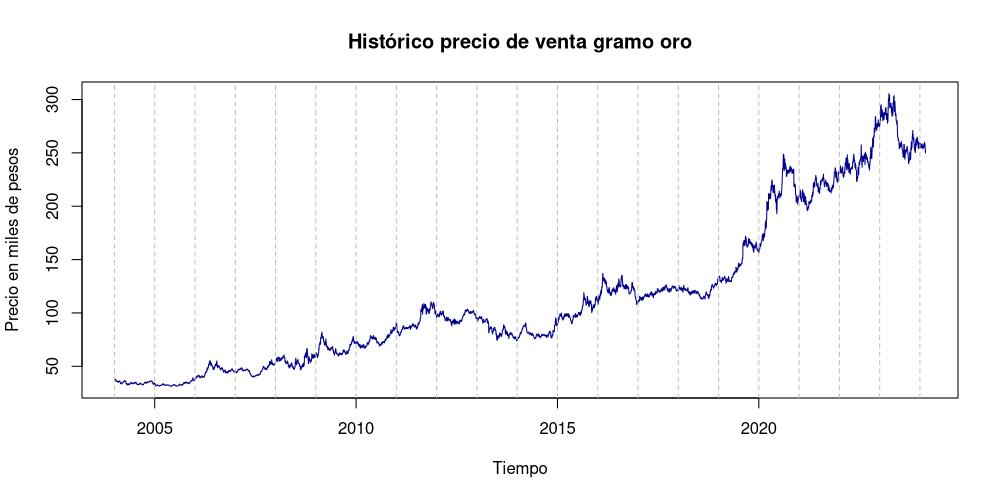

In [178]:
%%R -o leche -w 10 -h 5 --units in -r 100
source(paste0(Ruta,'Script análisis/Oro: Lectura de datos.R'))
abline(v = 2004:2024, col = 'gray', lty = 'dashed')

---

# **Análisis descriptivo**

En el avance 1, se realizaron los respectivos análisis de homocedasticidad, tendencia y estacionalidad para cada una de las series obteniendo los siguientes resultados:

## **Volumen de acopio nacional de leche (Frecuencia mensual)** 🐮

### **Estabilización de la varianza**

Al buscar un $\lambda$ para la transformación Box Cox encontramos que el que maximiza la log verosimilitud es $3.15$  apróximadamente por lo que se aplica la transformación obteniendo lo siguiente:

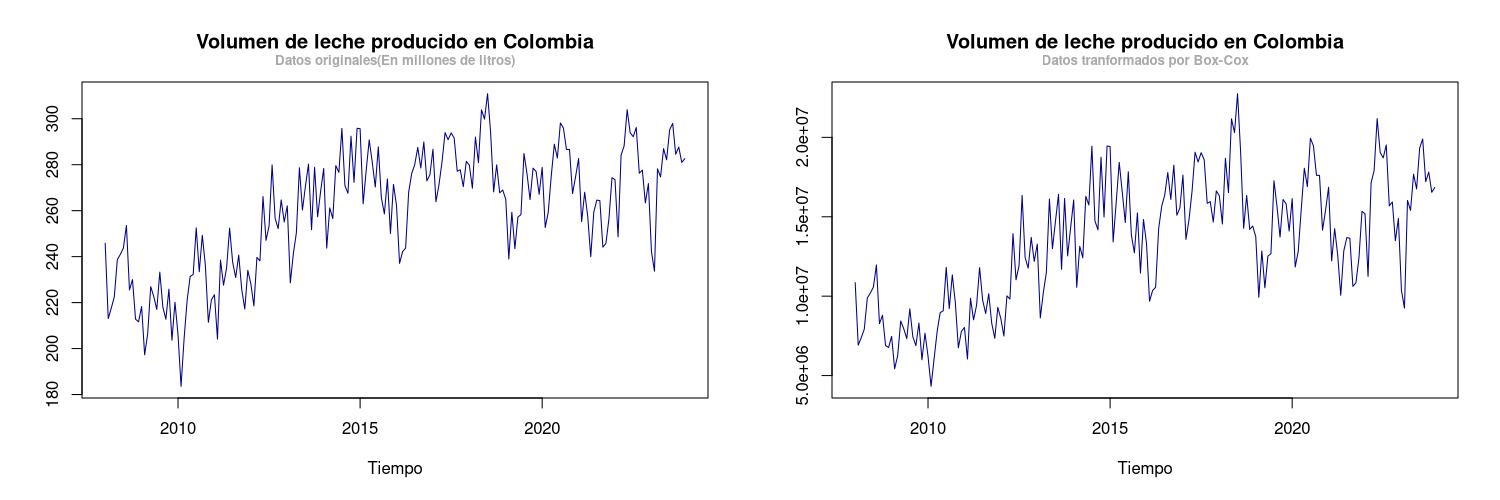

In [179]:
%%R -w 15 -h 5 --units in -r 100
source(paste0(Ruta,'Script análisis/Leche: Análisis de varianza.R'))

Como la serie no cambia realmente de estructura sino que aumenta de forma drástica su escala, se decide no aplicar la transformación Box Cox.

### **Eliminación de tendencia**

La serie claramente presenta cierta tendencia que al no ser completamente lineal se decide aplicar suavizamiento kernel:

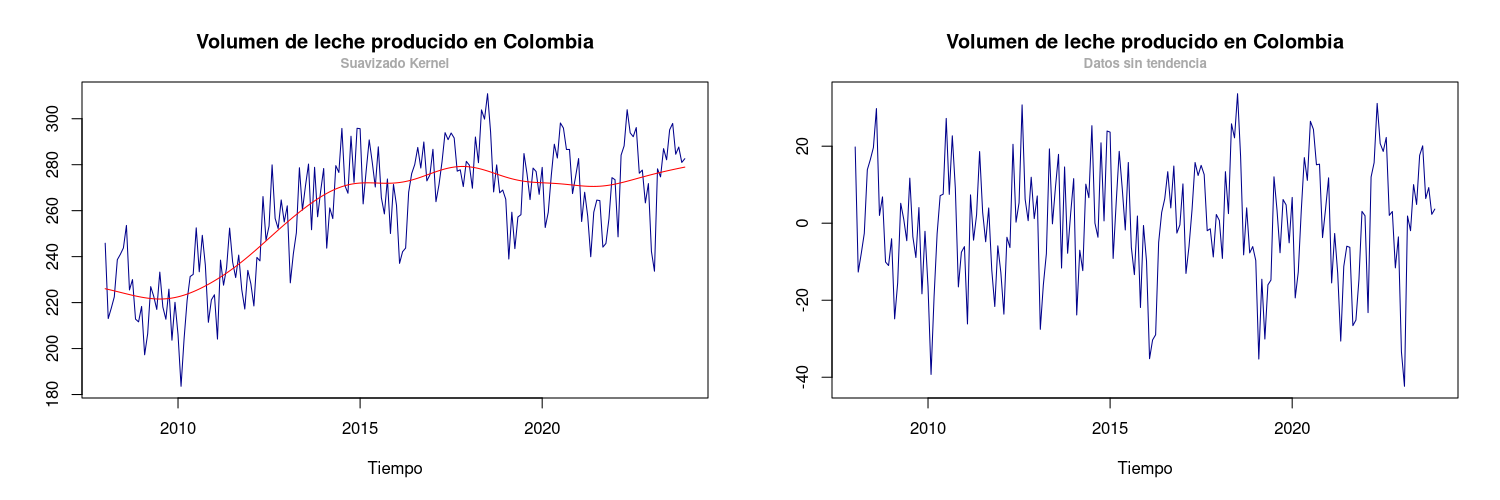

In [180]:
%%R -o leche -w 15 -h 5 --units in -r 100
# -o leche pasa el objeto leche a python como un array: Este objeto se utilizará en los árboles de decisión
# pues estos on útiles para datos sin tendencia
source(paste0(Ruta,'Script análisis/Leche: Eliminación de la tendencia.R'))

### **Análisis de estacionalidad**

En este caso, se utiizaron distintas herramientas gráficas para determinar la estacionalidad de la serie. Sin embargo, aquí presentamos únicamente el periodograma, las subseries y el gráfico de retardos:

#### **Gráfico de retardos**

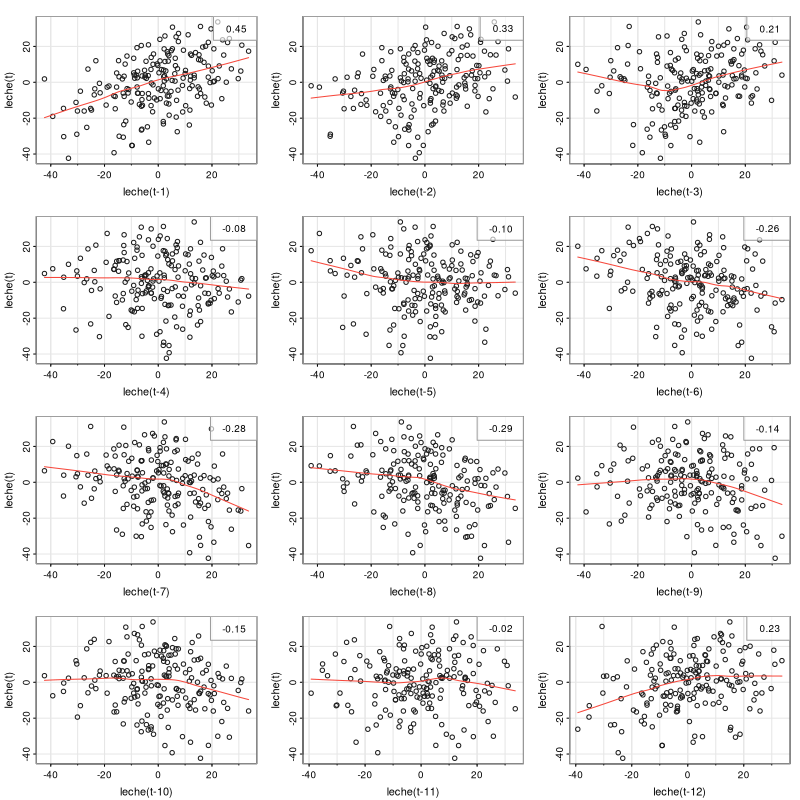

In [181]:
%%R -w 8 -h 8 --units in -r 100
astsa::lag1.plot(leche,12,corr = T)

#### **Subseries mensuales**

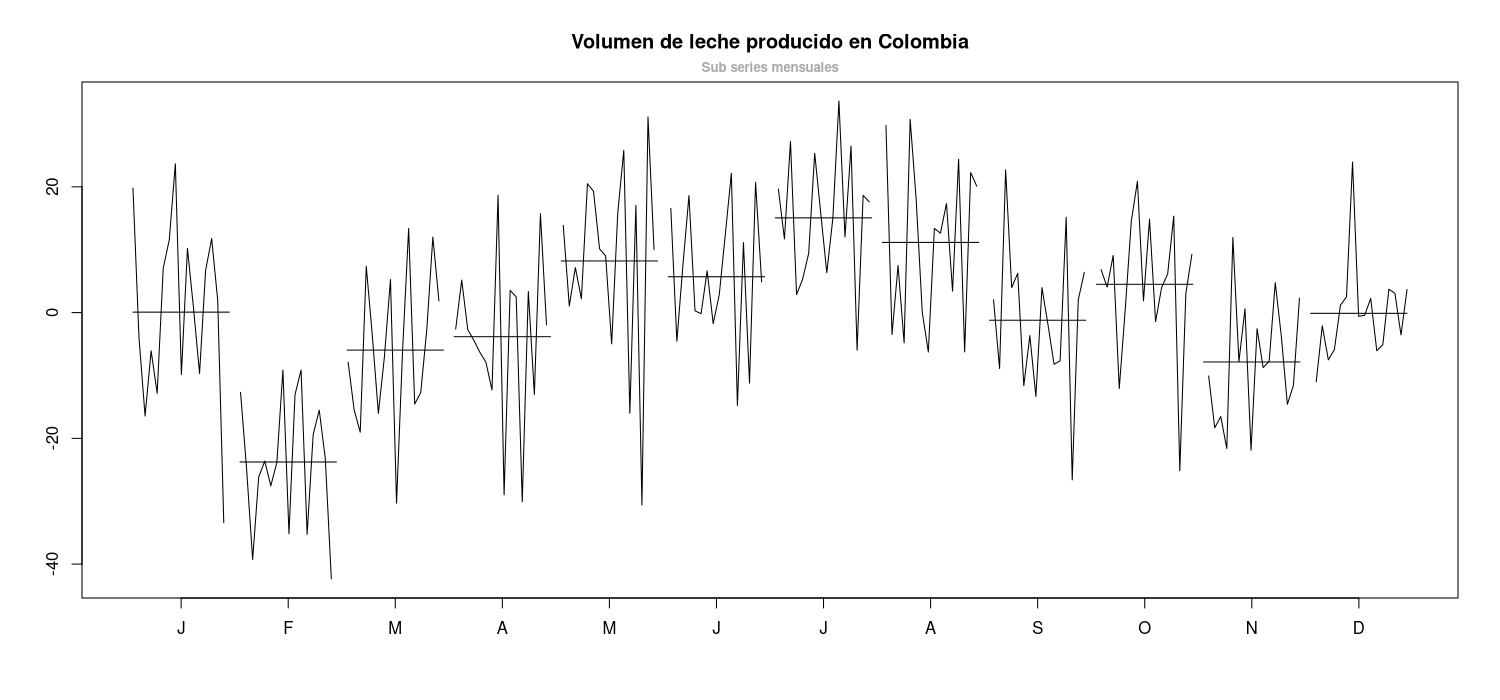

In [182]:
%%R -w 15 -h 7 --units in -r 100
monthplot(leche, ylab = '', main = 'Volumen de leche producido en Colombia')
mtext(bquote(bold('Sub series mensuales')),
      side = 3, line = 0.3, adj = 0.5, cex = 0.8, col = 'darkgray')

#### **Periodograma**

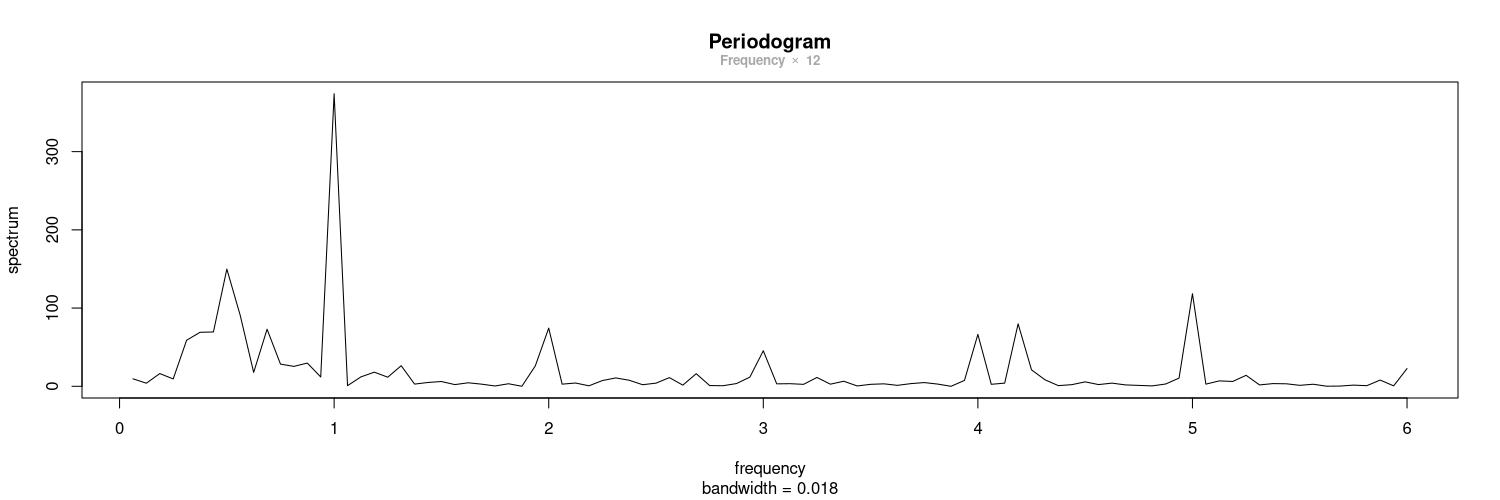

In [183]:
%%R -w 15 -h 5 --units in -r 100
library(latex2exp)
SpectrumLeche = spectrum(leche, log = 'no', main = 'Periodogram')
mtext(TeX('Frequency $\\times$ 12', bold = T),
      side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

Luego de probar distintos métodos, se decide utilizar variables dummys para intentar ajustar la estacionalidad de la serie. Los resultados se encuentran a continuación:

El valor máximo no. 1  en el que se máximiza el periodograma es 374.0577 
en la frecuencia  1 
El valor máximo no. 2  en el que se máximiza el periodograma es 149.8748 
en la frecuencia  0.5 
El valor máximo no. 3  en el que se máximiza el periodograma es 118.3689 
en la frecuencia  5 


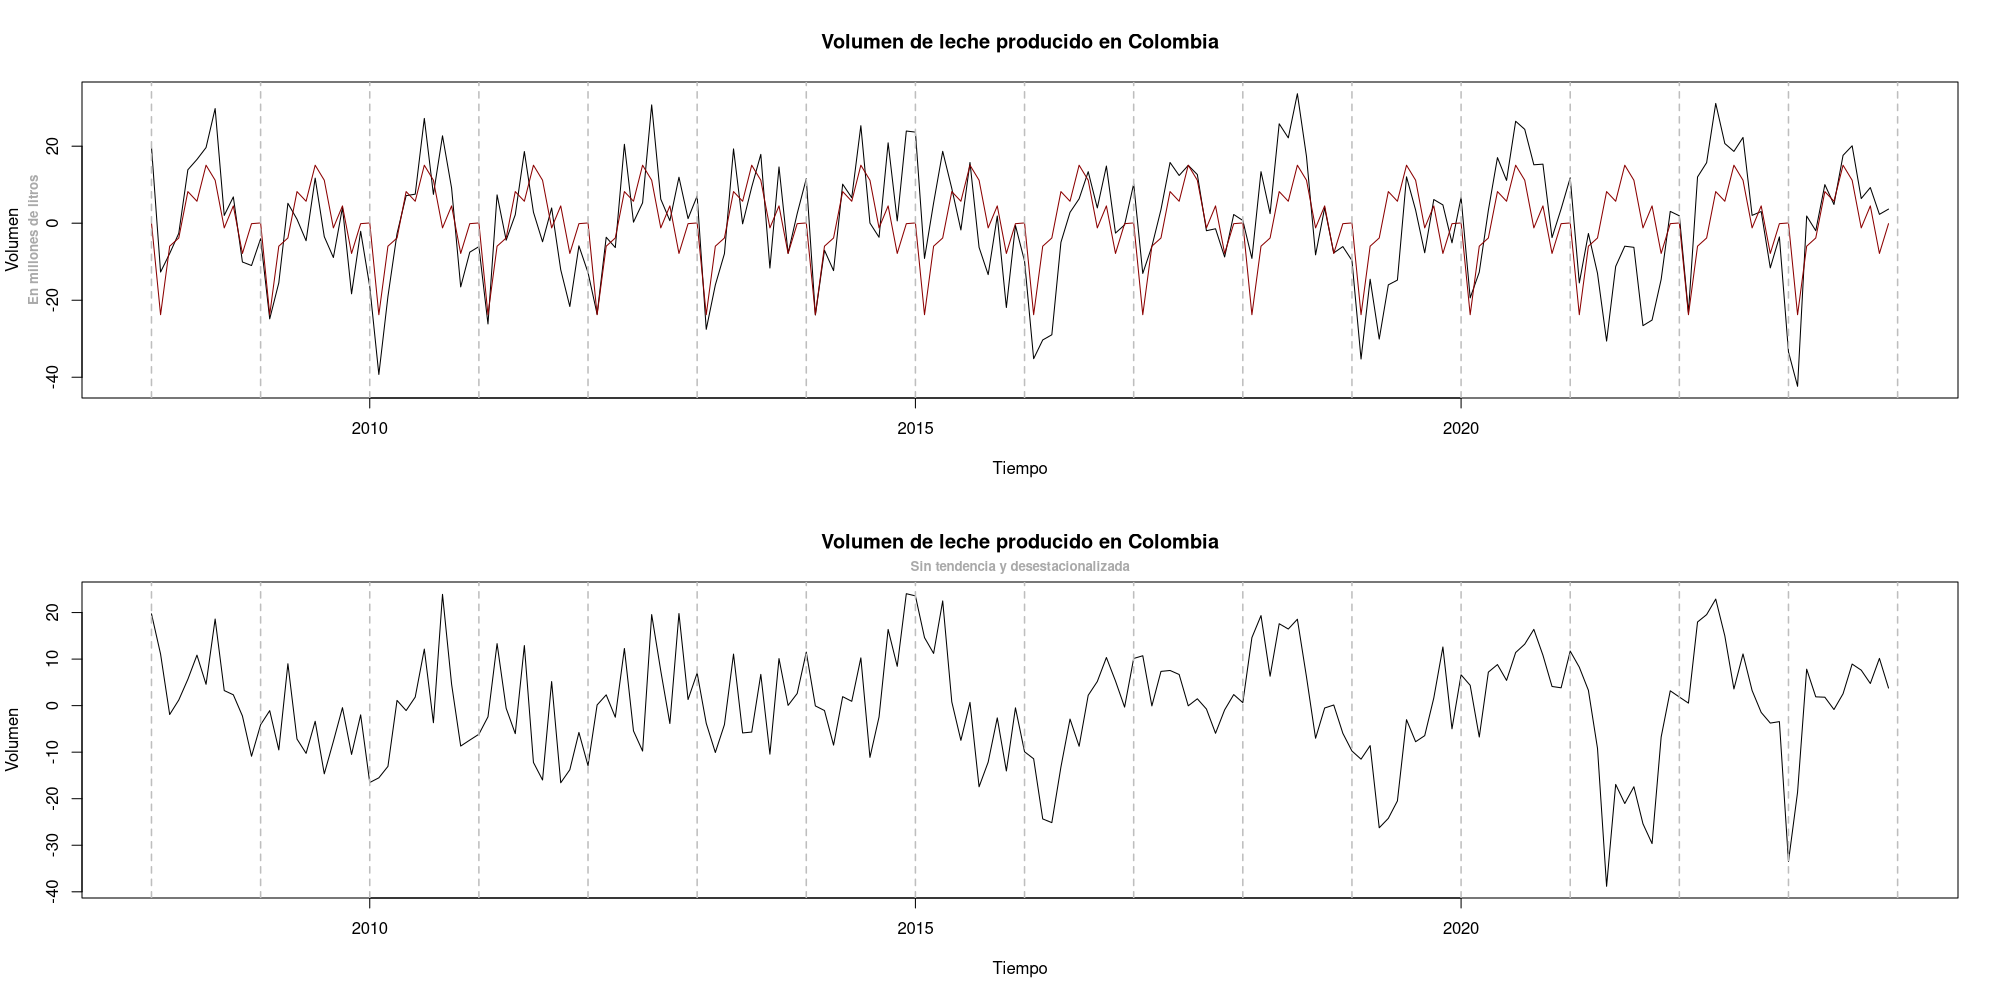

In [184]:
%%R -w 20 -h 10 --units in -r 100
source(paste0(Ruta, 'Script análisis/Leche: Estacionalidad.R'))

## **Precio del oro en Colombia (Frecuencia diaria) 🥇**

### **Estabilización de la varianza**

Al buscar el $\lambda$ para la transformación Box Cox, encontramos que para el caso de esta serie es muy cercano a cero por lo que aplicamos la transformación de logaritmo natural obteniendo lo siguiente:

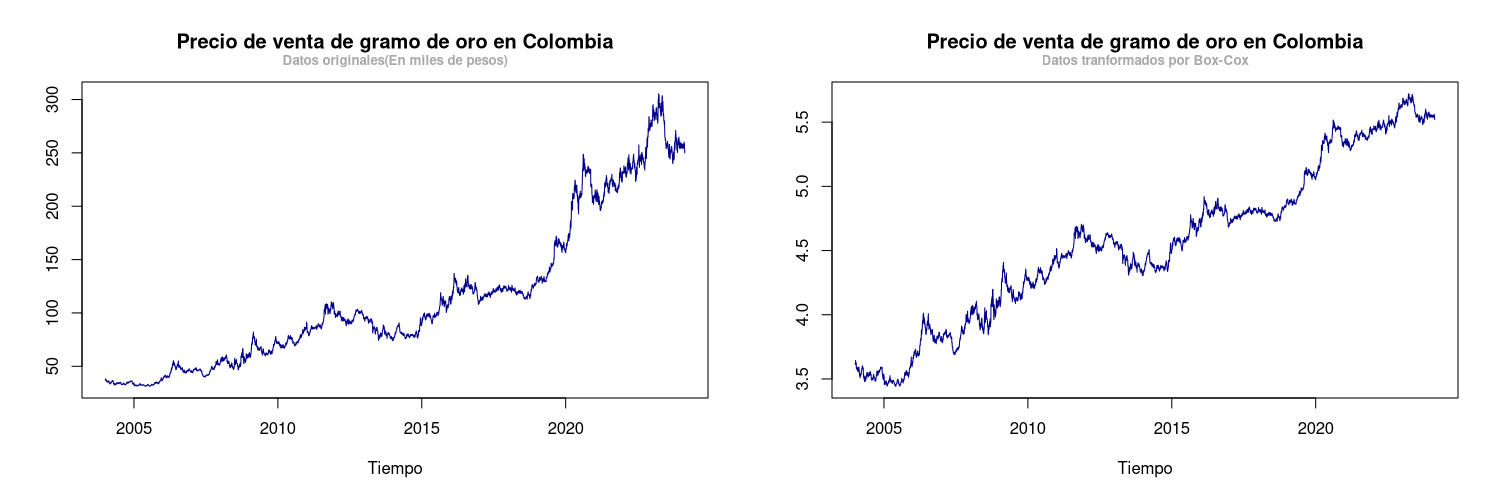

In [185]:
%%R -w 15 -h 5 --units in -r 100
source(paste0(Ruta, 'Script análisis/Oro: Análisis de varianza.R'))

Por lo que se decide usar la serie transformada en cambio de la original debido a que parece que de cierta forma si estabiliza la variabilidad de la serie especialmente para los últimos años

### **Eliminación de tendencia**

La serie claramente parece presentar una tendencia positiva no lineal completamente por lo que luego de explorar varios métodos se decide eliminnar la tendencia de la misma mediante ajuste de diferenciación a un retraso:

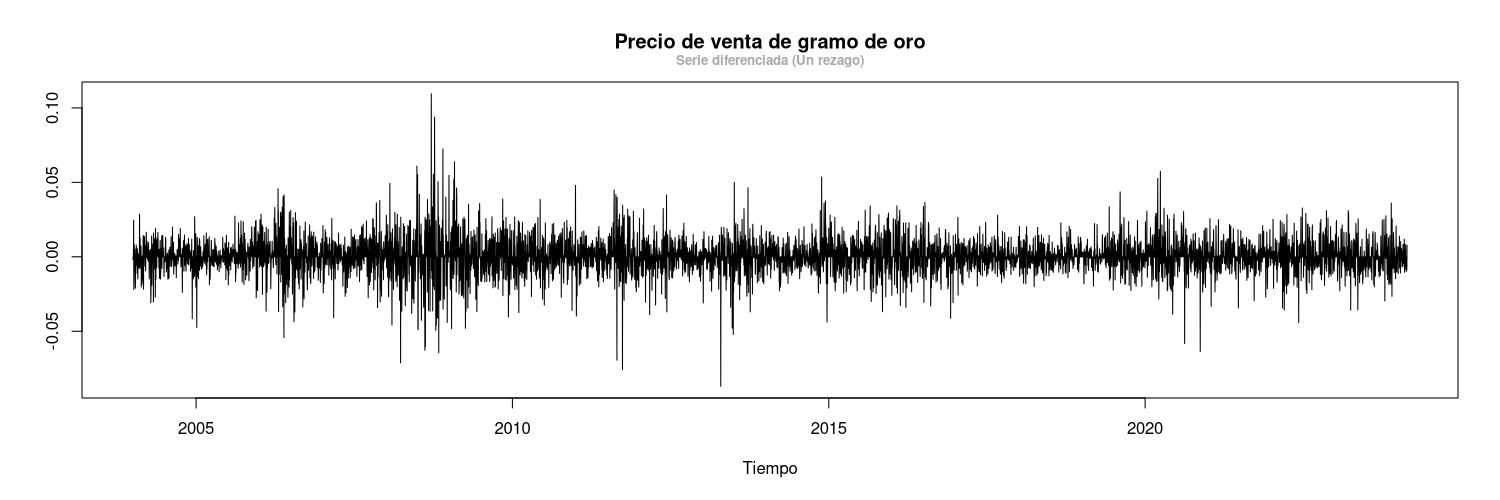

In [186]:
%%R -o diffOro -w 15 -h 5 --units in -r 100
source(paste0(Ruta,'Script análisis/Oro: Eliminación de la tendencia.R'))

Note que nuevamente con la opción `-o diffOro` sacamos la serie sin tendencia del entorno de `R` al entorno de `python`.

In [187]:
type(diffOro)

numpy.ndarray

### **Análisis de estacionalidad**

En general las autocorrelaciones son bajas. Hay autocorrelación negativa para los rezagos para las variables que están a 8, 34 y 40, las más prominentes son 15 y 46 rezagos.

Las positivas están a 20 y 50 rezagos.

(-0.04, 0.04)

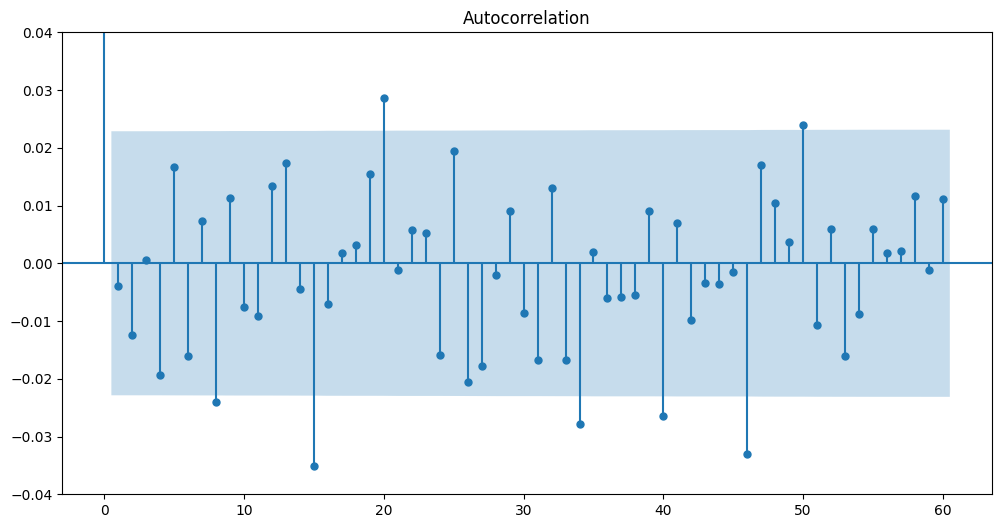

In [188]:
fig, ax = plot.subplots(figsize = (12,6))
plot_acf(diffOro,lags = 60, ax = ax)
ax.set_ylim([-0.04,0.04])

Hay autocorrelación parcial positiva para el rezago 20, negativa para los rezagos 8, 34, 40, y las más prominentes son a 15 y 46

(-0.04, 0.04)

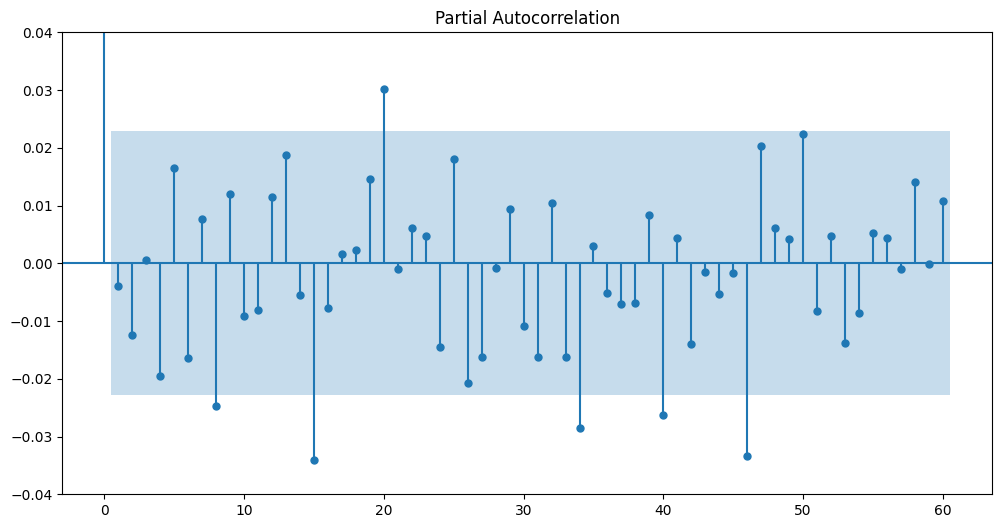

In [189]:
fig, ax = plot.subplots(figsize=(12,6))
plot_pacf(diffOro,lags=60, ax=ax)
ax.set_ylim([-0.04,0.04])

---

# **Árboles de decisión**

Para los árboles de decisión, tendremos en cuenta lo encontrado en la sección de estacionalidad para escoger algunas posibles opciones de rezagos y además utilizaremos las series sin tendencia:

## **Volumen de acopio nacional de leche (Frecuencia mensual)** 🐮

Como en esta serie, tenemos solamente 192 datos es necesario utilizar validación cruzada para ajustar los hiperparámetros. Además de esto, se escoge el último año (2023) de la serie para servir como datos de prueba o test. Sin embargo, antes de iniciar se debe cambiar el objeto leche de tipo `array` dentro de python a tipo `pd.Series`:

In [190]:
type(leche)

numpy.ndarray

In [191]:
date_index = pd.date_range(start = '2008-01', periods = len(leche), freq = 'M')
leche = pd.Series(leche, index = date_index)
leche

2008-01-31    19.795864
2008-02-29   -12.682066
2008-03-31    -7.872412
2008-04-30    -2.623688
2008-05-31    13.881874
                ...    
2023-08-31    20.100389
2023-09-30     6.408911
2023-10-31     9.259564
2023-11-30     2.303314
2023-12-31     3.667490
Freq: M, Length: 192, dtype: float64

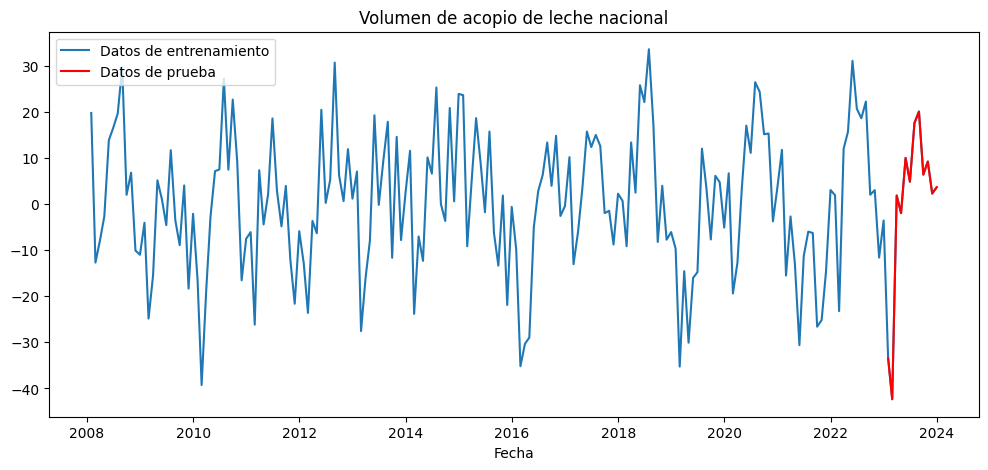

In [192]:
leche_train = leche[0:-12]
leche_test = leche[-12:len(leche)]
plot.figure(figsize = (12,5))

# Datos de entrenamiento
plot.plot(leche.index, leche, label = 'Datos de entrenamiento')

# Datos de prueba
plot.plot(leche_test.index, leche_test, color='red', label='Datos de prueba')

# Leyenda
plot.title('Volumen de acopio de leche nacional')
plot.xlabel('Fecha')
plot.legend(loc = 'upper left')

#### **Selección de rezagos y entrenamiento del árbol**

En cuanto al entrenamiento del árbol en sí, usaremos la función `ForeCasterAutoreg` del paquete `skforecast.ForecasterAutoreg`:

En cuanto a los rezagos que se utilizarán, tenemos que tener en cuenta que a medida que más lejanos estén lso rezagos más datos perderemos y debido a la cantidad limitada de datos es preferible no escoger rezagos tan lejanos. Además de esto, como la idea es generar árboles para distintos rezagos se escogieron los siguientes:

- Del 1 al 12 de forma secuencial.
- 1, 6 y 12 meses.
- 1, 3, 6,9 y 12 meses.
- 1 y 12 meses.
- 6 y 12 meses.
- 4, 8 y 12 meses.

Además de esto, también necesitamos definir la profundidad máxima del árbol. En este caso, escogemos 10 como máxima profundidad del árbol.

In [193]:
rezagos = [1,2,3,4,5,6,7,8,9,10,11,12,
          [1,6,12],
          [1,3,6,9,12],
          [1,12],
          [6,12],
          [4,8,12]]
hiperparametros = {'max_depth': list(range(1,15)), 
                  'min_samples_leaf': list(range(6,15))}

Una vez definidos estos, creamos un árbol inicial:

In [194]:
tree_leche = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(random_state = 1305),
    lags = 6 # Este valor posiblemente cambiará con la busquéda de hiperparámetros
)

Y ajustamos el árbol usando la búsqueda de grilla. Además, también revisaremos si existe alguna diferencia entre el número de pasos hacia delante para los que se entrenó el modelo y la precisión respecto al conjunto de prueba:

In [37]:
tuning_leche = pd.DataFrame()
for step in range(1,13):
    print(f'{12 * "="}\tEntrenando al modelo {step} pasos adelante\t{12 * "="}')
    tuning = grid_search_forecaster(
    forecaster = tree_leche,
    y = leche_train,
    param_grid = hiperparametros,
    lags_grid = rezagos,
    steps = step,
    refit = True,
    metric = 'mean_squared_error',
    initial_train_size = int(len(leche_train) * 0.8),
    fixed_train_size = False,
    return_best = True,
    verbose = False)

    tuning['Steps'] = step
    tuning['MSE test'] = mean_squared_error(y_true = leche_test,
                                            y_pred = tree_leche.predict(12))
    tuning = tuning[0:1]
    tuning_leche = pd.concat([tuning_leche, tuning], axis = 0)

============	Entrenando al modelo 1 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 10, 'min_samples_leaf': 8}
  Backtesting metric: 125.9081336572329

============	Entrenando al modelo 2 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 8, 'min_samples_leaf': 8}
  Backtesting metric: 137.456790218802

============	Entrenando al modelo 3 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 6, 'min_samples_leaf': 8}
  Backtesting metric: 145.46871241216525

============	Entrenando al modelo 4 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 6, 'min_samples_leaf': 7}
  Backtesting metric: 125.03426045185913

============	Entrenando al modelo 5 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 11, 'min_samples_leaf': 12}
  Backtesting metric: 140.55291907051054

============	Entrenando al modelo 6 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 6, 'min_samples_leaf': 7}
  Backtesting metric: 147.31250982803087

============	Entrenando al modelo 7 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 6, 'min_samples_leaf': 9}
  Backtesting metric: 142.75154901436971

============	Entrenando al modelo 8 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 4, 'min_samples_leaf': 12}
  Backtesting metric: 179.02847019128455

============	Entrenando al modelo 9 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 14, 'min_samples_leaf': 12}
  Backtesting metric: 169.62691203073695

============	Entrenando al modelo 10 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 4, 'min_samples_leaf': 12}
  Backtesting metric: 203.9035568497967

============	Entrenando al modelo 11 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 6, 'min_samples_leaf': 7}
  Backtesting metric: 150.6289373132537

============	Entrenando al modelo 12 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7 8] 
  Parameters: {'max_depth': 8, 'min_samples_leaf': 10}
  Backtesting metric: 155.4785344297701



El modelo que mejor se desempeño en el conjunto de entrenamiento fue:

In [38]:
tuning_leche.sort_values(by = 'mean_squared_error')

,lags,params,mean_squared_error,max_depth,min_samples_leaf,Steps,MSE test
424,"[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 7}",125.034260,6,7,4,91.643669
461,"[1, 2, 3, 4]","{'max_depth': 10, 'min_samples_leaf': 8}",125.908134,10,8,1,130.371382
443,"[1, 2, 3, 4]","{'max_depth': 8, 'min_samples_leaf': 8}",137.456790,8,8,2,130.371382
600,"[1, 2, 3, 4, 5]","{'max_depth': 11, 'min_samples_leaf': 12}",140.552919,11,12,5,324.858847
426,"[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 9}",142.751549,6,9,7,331.539654
425,"[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 8}",145.468712,6,8,3,125.298602
550,"[1, 2, 3, 4, 5]","{'max_depth': 6, 'min_samples_leaf': 7}",147.312510,6,7,6,375.375850
550,"[1, 2, 3, 4, 5]","{'max_depth': 6, 'min_samples_leaf': 7}",150.628937,6,7,11,375.375850
949,"[1, 2, 3, 4, 5, 6, 7, 8]","{'max_depth': 8, 'min_samples_leaf': 10}",155.478534,8,10,12,158.649368
879,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 14, 'min_samples_leaf': 12}",169.626912,14,12,9,356.846743


El modelo que mejor se desempeño en el conjunto de prueba fue:

In [39]:
tuning_leche.sort_values(by = 'MSE test')

,lags,params,mean_squared_error,max_depth,min_samples_leaf,Steps,MSE test
424,"[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 7}",125.034260,6,7,4,91.643669
425,"[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 8}",145.468712,6,8,3,125.298602
461,"[1, 2, 3, 4]","{'max_depth': 10, 'min_samples_leaf': 8}",125.908134,10,8,1,130.371382
443,"[1, 2, 3, 4]","{'max_depth': 8, 'min_samples_leaf': 8}",137.456790,8,8,2,130.371382
949,"[1, 2, 3, 4, 5, 6, 7, 8]","{'max_depth': 8, 'min_samples_leaf': 10}",155.478534,8,10,12,158.649368
663,"[1, 2, 3, 4, 5, 6]","{'max_depth': 4, 'min_samples_leaf': 12}",203.903557,4,12,10,277.548561
411,"[1, 2, 3, 4]","{'max_depth': 4, 'min_samples_leaf': 12}",179.028470,4,12,8,282.864272
600,"[1, 2, 3, 4, 5]","{'max_depth': 11, 'min_samples_leaf': 12}",140.552919,11,12,5,324.858847
426,"[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 9}",142.751549,6,9,7,331.539654
879,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 14, 'min_samples_leaf': 12}",169.626912,14,12,9,356.846743


### **Modelo final**

Como el argumento `refit` tiene valor verdadero dentro de la función de búsqueda por grilla, en este momento el árbol esta ajustado con la última mejor configuración. Es decir, con profundidad 8 y 12 pasos hacia delante:

In [17]:
tree_leche

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(random_state=1305) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 1305, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2024-06-27 11:56:21 
Last fit date: None 
Skforecast version: 0.11.0 
Python version: 3.12.3 
Forecaster id: None 

Es necesario reajustar el modelo para obtener el modelo final:

In [100]:
tree_leche = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(random_state = 1305, max_depth=6, min_samples_leaf=7),
    lags = 4
)

tree_leche.fit(leche_train)

Revisamos que se estén generando las mismas predicciones:

In [101]:
predicciones = tree_leche.predict(12)

In [102]:
MSE = mean_squared_error(y_true = leche_test, y_pred =predicciones)

print(f'MSE test: {MSE}')

MSE test: 91.6436693301634


#### **Predicciones puntuales**

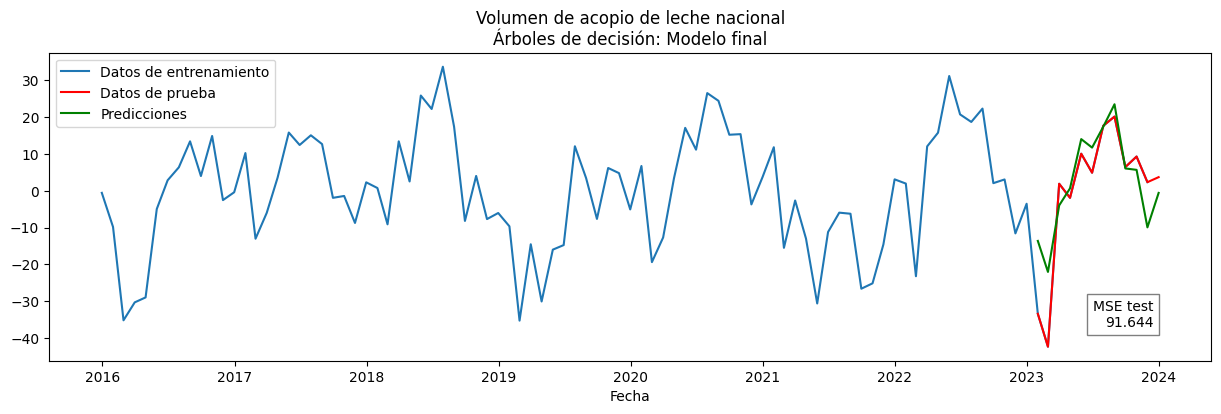

In [103]:
plot.figure(figsize=(15,4))

# Datos de entrenamiento
plot.plot(leche.index[-97:-1], leche[-97:-1], label = 'Datos de entrenamiento')

# Datos de prueba
plot.plot(leche_test.index, leche_test, color='red', label='Datos de prueba')

# Predicciones
plot.plot(leche_test.index, predicciones, color = 'green', label = 'Predicciones')

# Leyenda
plot.title('Volumen de acopio de leche nacional\nÁrboles de decisión: Modelo final')
plot.xlabel('Fecha')
plot.legend(loc = 'upper left')

# Valor de MSE
plot.text(0.95,0.1, f'MSE test\n{MSE:.3f}', horizontalalignment='right', verticalalignment='bottom', 
          transform=plot.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

plot.show()

Tenga en cuenta que estas predicciones no están en la escala original por lo que tenemos que volver a sumarlo los resultados del suavizamiento Kernel pare regresarlo a la escala original y estos podemos traerlos al entorno de python de la siguiente forma:

In [104]:
%%R -o ModeloKernelLeche
str(ModeloKernelLeche)

List of 2
 $ x: num [1:192] 2008 2008 2008 2008 2008 ...
 $ y: num [1:192] 226 226 225 225 225 ...


Y en `python` este objeto queda guardado como un diccionario:

In [105]:
type(ModeloKernelLeche)

rpy2.rlike.container.OrdDict

In [195]:
# Devolviendo los datos a su estado con tendencia
leche_train = leche_train + ModeloKernelLeche['y'][0:-12]
leche_test = leche_test + ModeloKernelLeche['y'][-13:-1]
leche = leche + ModeloKernelLeche['y']

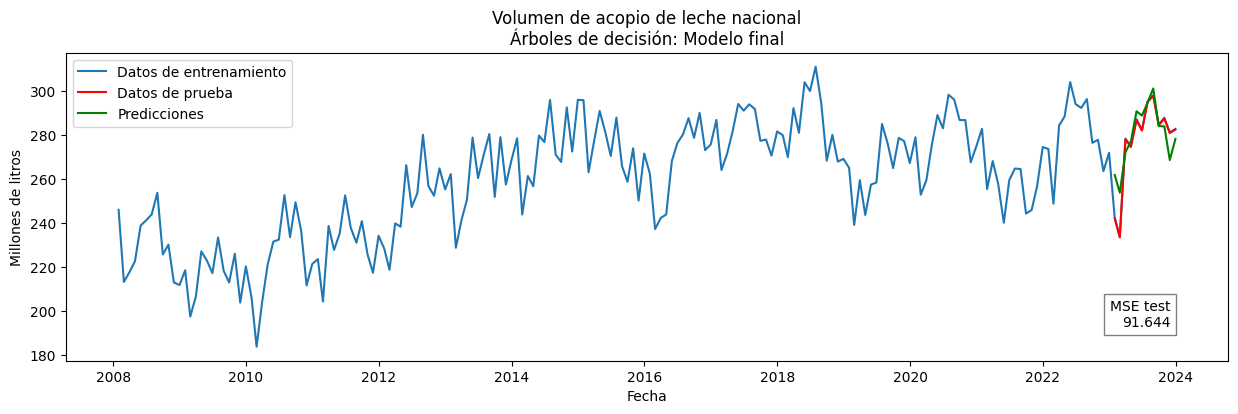

In [107]:
plot.figure(figsize=(15,4))

# Datos de entrenamiento
plot.plot(leche.index, leche, label = 'Datos de entrenamiento')

# Datos de prueba
plot.plot(leche_test.index, leche_test, color='red', label = 'Datos de prueba')

# Predicciones
plot.plot(leche_test.index, (predicciones + ModeloKernelLeche['y'][-13:-1]), 
          color = 'green', label = 'Predicciones')

# Leyenda
plot.title('Volumen de acopio de leche nacional\nÁrboles de decisión: Modelo final')
plot.xlabel('Fecha')
plot.ylabel('Millones de litros')
plot.legend(loc = 'upper left')

# Valor de MSE
plot.text(0.95,0.1, f'MSE test\n{MSE:.3f}', horizontalalignment='right', verticalalignment='bottom', 
          transform=plot.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

plot.show()

#### **Estructura del árbol**

El rezago más importante para la predicción en este caso es el primer rezago:

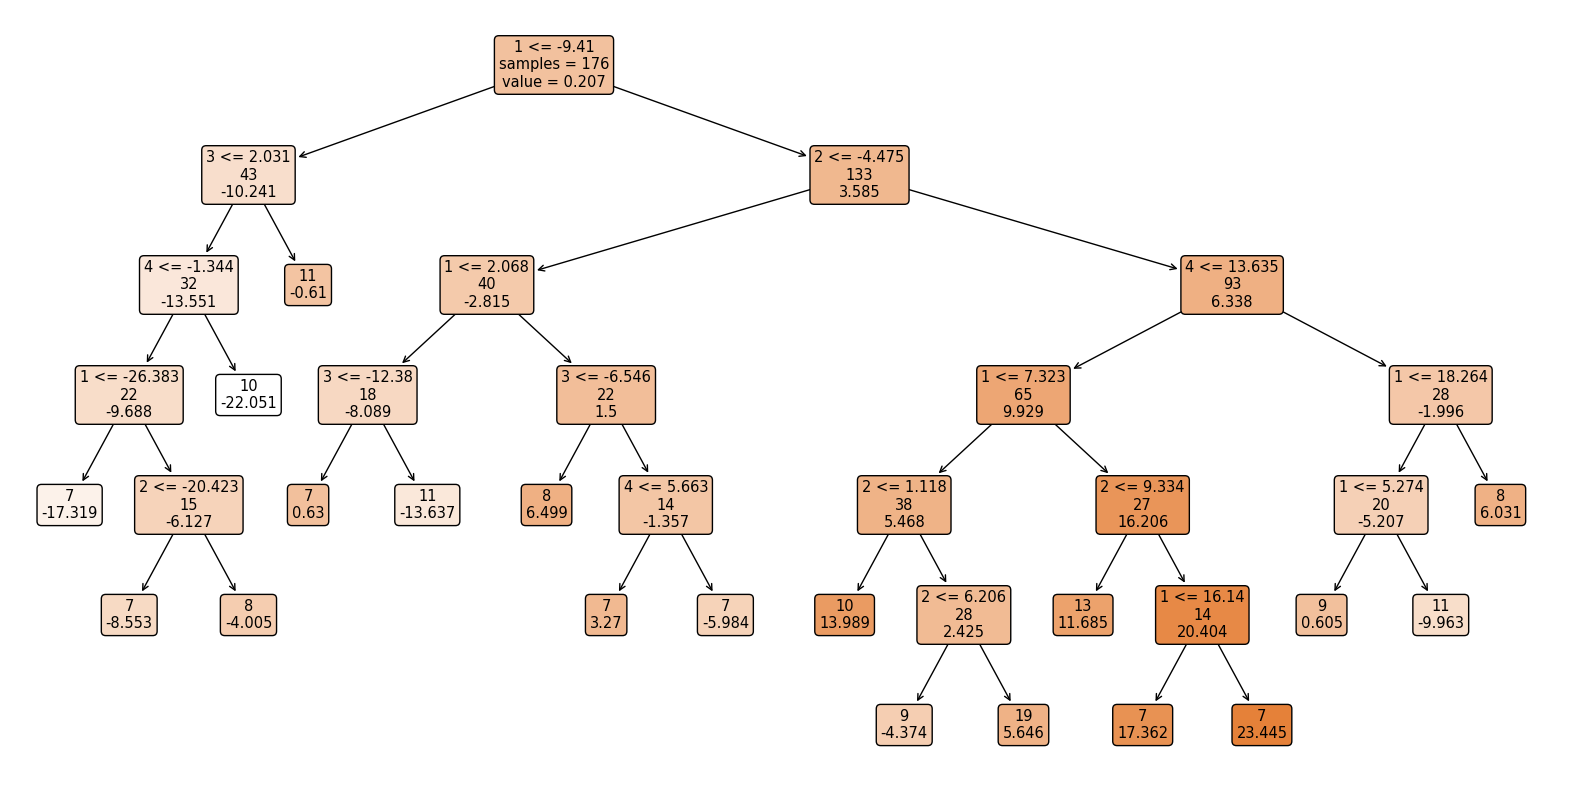

In [108]:
# Crear una visualización del árbol
plot.figure(figsize=(20,10))
plot_tree(tree_leche.regressor, #max_depth = 5,
          filled=True, feature_names=tree_leche.lags, rounded = True,
          impurity = False, label = 'root')
plot.show()

#### **Predicciones de intervalo**

In [109]:
intervalos = tree_leche.predict_interval(steps = 12,
                           interval = [0.025, 99.75],
                           n_boot = 1000)
for i in intervalos.keys():
    intervalos[i] = intervalos[i] + ModeloKernelLeche['y'][-13:-1]

intervalos

,pred,lower_bound,upper_bound
2023-01-31,261.694011,234.903067,293.889267
2023-02-28,253.623795,226.832851,315.876150
2023-03-31,272.005037,231.900458,315.703924
2023-04-30,276.966905,235.835368,318.216061
2023-05-31,290.644519,237.292726,317.105811
2023-06-30,288.651875,236.784265,318.845664
2023-07-31,294.632559,234.296985,317.626836
2023-08-31,301.011632,235.678735,320.433766
2023-09-30,283.886344,236.385905,321.471777
2023-10-31,283.784353,236.971323,321.887575


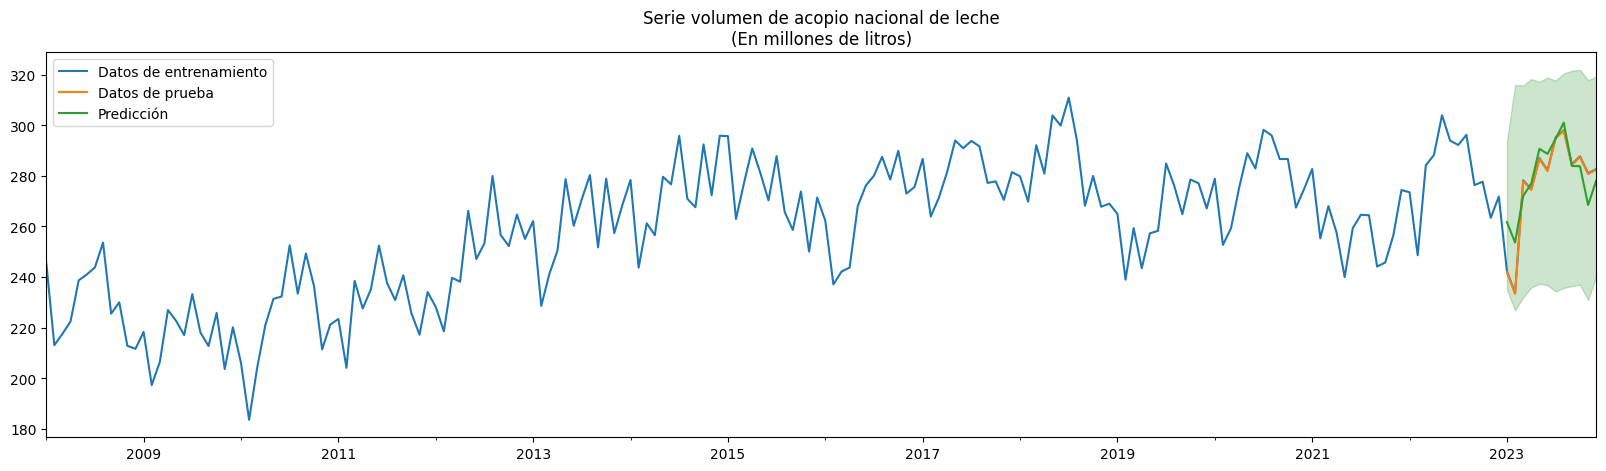

In [110]:
fig, ax = plot.subplots(figsize=(20,5))
leche.plot(ax=ax, label = 'Datos de entrenamiento')
leche_test.plot(ax=ax, label = 'Datos de prueba')
intervalos['pred'].plot(ax=ax, label = 'Predicción')
ax.fill_between(
    intervalos.index,
    intervalos['lower_bound'],
    intervalos['upper_bound'],
    color = 'green',
    alpha = 0.2
)
plot.title('Serie volumen de acopio nacional de leche\n(En millones de litros)')
ax.legend(loc = 'upper left')

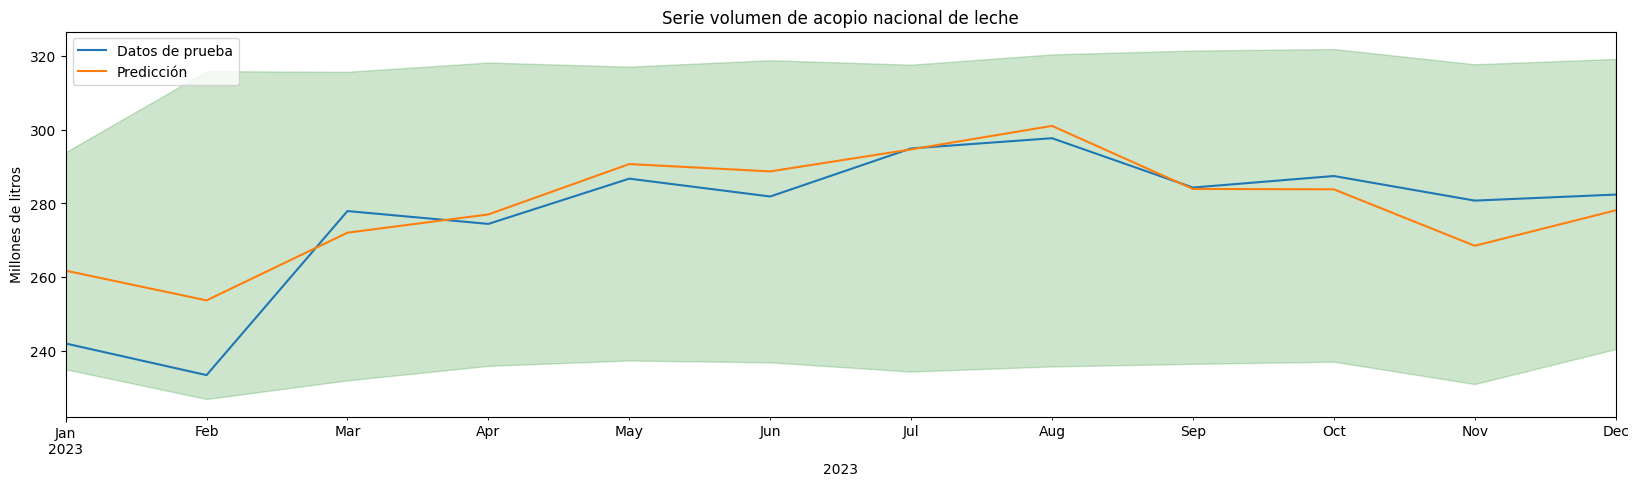

In [111]:
fig, ax = plot.subplots(figsize=(20,5))
leche_test.plot(ax=ax, label = 'Datos de prueba')
intervalos['pred'].plot(ax=ax, label = 'Predicción')
ax.fill_between(
    intervalos.index,
    intervalos['lower_bound'],
    intervalos['upper_bound'],
    color = 'green',
    alpha = 0.2
)
plot.title('Serie volumen de acopio nacional de leche')
plot.ylabel('Millones de litros')
plot.xlabel('2023')
ax.legend(loc = 'upper left')

## **Precio del oro en Colombia (Frecuencia diaria) 🥇**

Nuevamente, tenemos que hacer que los datos se guarden en un objeto de tipo `ps.Series` en `python` para poder trabajar apropiadamente nuestra serie:

In [14]:
date_index = pd.date_range(start = '2004-01', periods = len(diffOro), freq = 'D')
oro = pd.Series(diffOro, index = date_index)
oro

2004-01-01   -0.001902
2004-01-02    0.000000
2004-01-03    0.000000
2004-01-04    0.006033
2004-01-05    0.024586
                ...   
2024-02-11   -0.009800
2024-02-12   -0.006865
2024-02-13   -0.006025
2024-02-14   -0.008684
2024-02-15    0.007784
Freq: D, Length: 7351, dtype: float64

Además de esto, también utilizaremos validación cruzada para el entrenamiento de nuestra serie por lo que necesitamos dividir nuestros datos en datos de entrenamiento y prueba:

In [15]:
oro_train = oro[0:-2000]
oro_test = oro[-2000:len(oro)]
print(f'Los datos de entrenamiento y prueba quedaron con:\n\t - {len(oro_train)} datos\n\t - {len(oro_test)} datos\nrespectivamente')

Los datos de entrenamiento y prueba quedaron con:
	 - 5351 datos
	 - 2000 datos
respectivamente


Quedando los datos separados así:

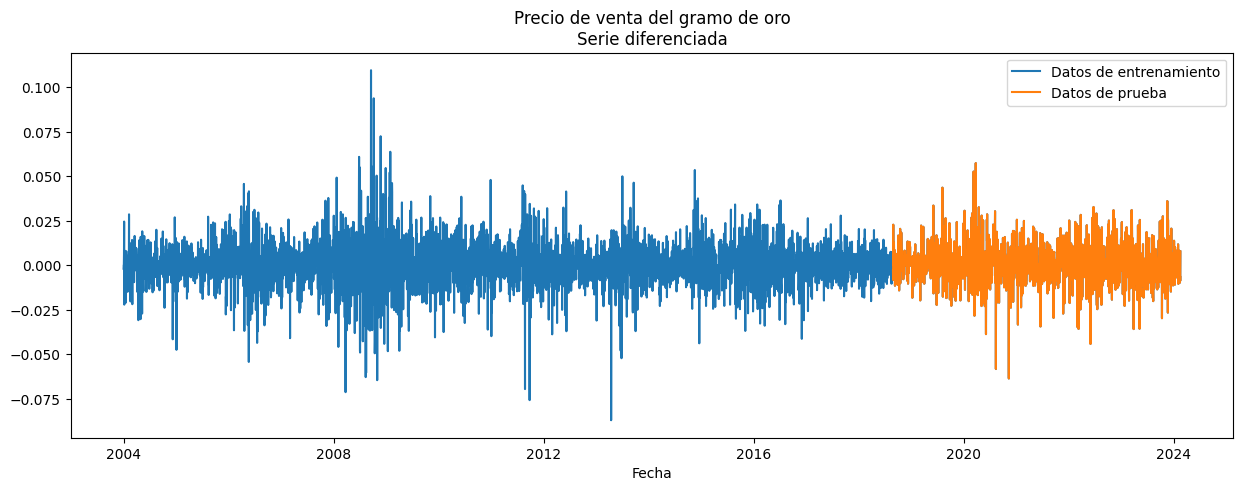

In [16]:
# Tamaño del gráfico
plot.figure(figsize = (15,5))

# Datos de entrenamiento
plot.plot(oro.index, oro, label = 'Datos de entrenamiento')

# Datos de prueba
plot.plot(oro_test.index, oro_test, label = 'Datos de prueba')

# Títulos y leyendas
plot.title('Precio de venta del gramo de oro\nSerie diferenciada')
plot.xlabel('Fecha')
plot.legend(loc = 'upper right')

### **Selección de rezagos y entrenamiento del árbol**
Como se dijo anteriormente, se emplea validación cruzada para la selección de los mejores hiperparámetros.

In [17]:
rezagos = [1,2,3,4,5,6,7,8,15,20,46]
parametros = {'max_depth': list(range(1,76))}

Una vez definidos los hierparámetros para implementar `grid_search` creamos un modelos de árbol básico para ser objetivo de nuestra busquéda:

In [18]:
tree_oro = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(random_state=0),
    lags = [1,2,3,4,5,6,7,8,15,20,46],
)

Y finalmente, aplicamos nuestra busquéda:

In [19]:
tuning_oro = grid_search_forecaster(
                        forecaster         = tree_oro,
                        y                  = oro_train,
                        param_grid         = parametros,
                        lags_grid          = rezagos,
                        steps              = 7,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(oro_train)*0.7),
                        fixed_train_size   = True,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 825.


lags grid:   0%|          | 0/11 [00:00<?, ?it/s]

params grid:   0%|          | 0/75 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 3}
  Backtesting metric: 7.951069283421595e-05



In [21]:
predicciones = tree_oro.predict(2000)

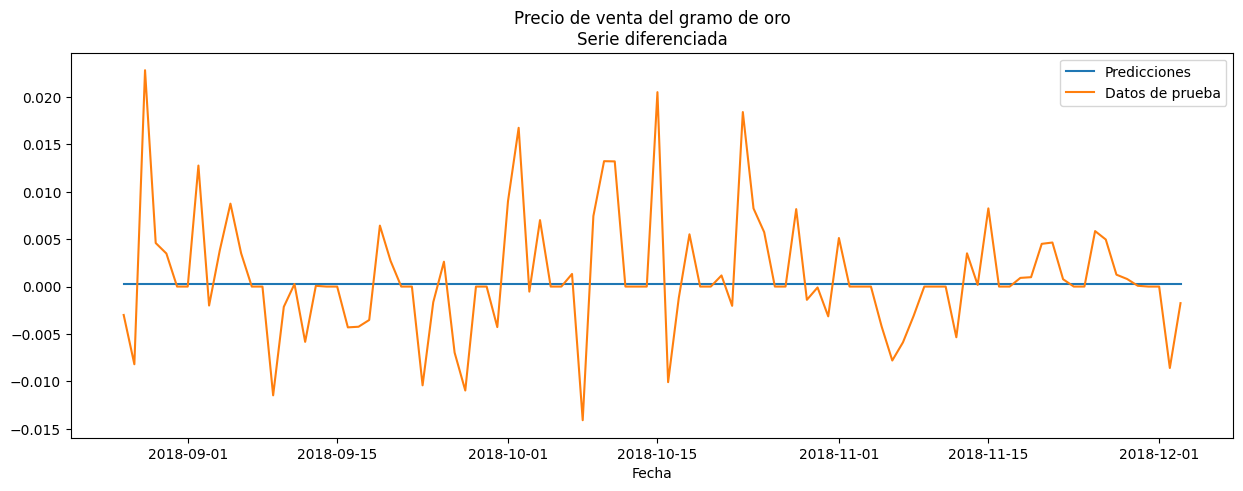

In [24]:
# Tamaño del gráfico
plot.figure(figsize = (15,5))

# Datos de entrenamiento
plot.plot(oro_test.index[0:100], predicciones[0:100] , label = 'Predicciones')

# Datos de prueba
plot.plot(oro_test.index[0:100], oro_test[0:100], label = 'Datos de prueba')

# Títulos y leyendas
plot.title('Precio de venta del gramo de oro\nSerie diferenciada')
plot.xlabel('Fecha')
plot.legend(loc = 'upper right')

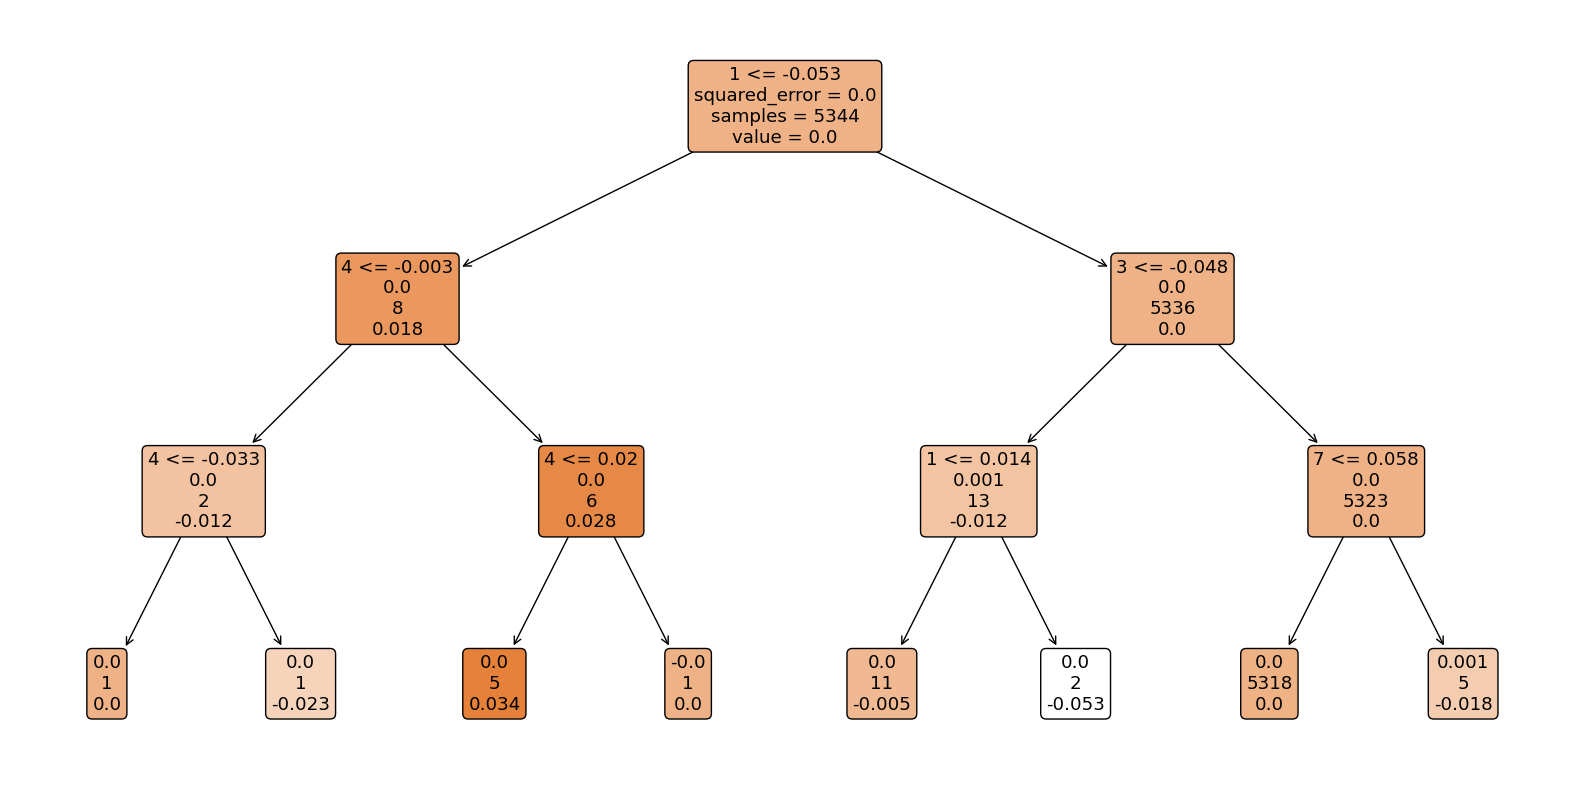

In [27]:
# Crear una visualización del árbol
plot.figure(figsize=(20,10))
plot_tree(tree_oro.regressor, #max_depth = 5,
          filled=True, feature_names=tree_oro.lags, rounded = True,
          impurity = True, label = 'root')
plot.show()

---

# **Filtro exponencial**

En esta sección se ajustan todas las posibles variaciones del filtro exponencial para revisar cuál es la mejor para cada serie:

## **Volumen de acopio nacional de leche (Frecuencia mensual)** 🐮

Aunque la serie claramente presente tendencia implementaremos inicialmente el método de suavizamiento exponencial simple. En este caso, usaremos la función `HoltWinters` del paquete `stats` de `R` por facilitar la implementación en ciclo de los distintos modelos. Esta función tiene como argumentos principales:

- x: Serie de tiempo
- alpha: Parámetro $\alpha$ para el suavizamiento Holt-Winters
- beta: Parámetro para la componente de tendencia
- gamma: Parámetro para la componente de estacionalidad
- seasonal: Parámetro para definir si la estacionalidad se agrega de forma exponencial o de forma lineal

La idea principal es genera todas las combinaciones posibles de filtros exponenciales a pesar de que el más apto posiblemente sea el filtro exponencial triple (Usando $\alpha$, $\beta$ y $\gamma$) debido a las evidencias que tenemos del análisis descriptivo tanto de la tendencia positiva de la serie así como su estacionalidad.

In [197]:
%%R -i leche_train,leche_test,leche
# Recuerde que en la sección de árboles de decisión devolvimos a los datos de volumen de acopio a su estado original 
# por lo que para usarlos acá no es necesario realizar ninguna transformación extra:

parametros = expand.grid('beta' = list(F, NULL), 'gamma' = list(F, NULL), 'seasonal' = list('additive', 'multiplicative'))

leche = ts(leche, start = 2008, freq = 12)
leche_train = ts(leche_train, start = 2008, freq = 12)
leche_test = ts(leche_test, start = 2023, freq = 12)

Aunque no es completamente necesario, con el fin de hacer comparativas dejaremos la división de los datos intacta para poder hacer comparaciones con los demás métodos aquí implementados. Recuerde que al finalizar la sección de árboles a los datos de entrenamiento y prueba se les devolvió su escala original, además tambień tenga en cuenta que para incluir la estacionalidad en el modelo se tiene que perder el primer ciclo completo de la serie:

In [418]:
%%R -o exponentialFilter_leche
exponentialFilter_leche = data.frame(matrix(ncol = 6, nrow = nrow(parametros)))
colnames(exponentialFilter_leche) = c('alpha', 'beta', 'gamma', 'seasonal','MSE', 'MSE test')
for (i in 1:nrow(parametros)){
    modeloExponencial = stats::HoltWinters(x = leche_train,
                                           alpha = NULL,
                                           beta = parametros$beta[[i]],
                                           gamma = parametros$gamma[[i]],
                                           seasonal = parametros$seasonal[[i]]) 
    # seasonal sólo debería tenerse en cuenta cuando se tiene un valor distinto a FALSE para gamma
    exponentialFilter_leche[i, c('alpha', 'beta', 'gamma', 'seasonal')] = c(modeloExponencial$alpha,
                                                                          modeloExponencial$beta,
                                                                          modeloExponencial$gamma,
                                                                          modeloExponencial$seasonal)
    exponentialFilter_leche[i, 'MSE'] = mean((leche_train - modeloExponencial$fitted[,'xhat'])**2)
    prediccion = predict(modeloExponencial, 12)
    exponentialFilter_leche[i, 'MSE test'] = mean((leche_test - prediccion)**2)
}

In [347]:
exponentialFilter_leche.sort_values(by = 'MSE')

,alpha,beta,gamma,seasonal,MSE,MSE test
3,0.497605659473481,FALSE,0.514877589216722,additive,137.128568,285.851844
4,0.517446588561401,0.0123159804595052,0.549867097378286,additive,140.874724,315.058967
7,0.486913011272521,FALSE,0.550123940781374,multiplicative,143.797830,316.588714
8,0.508497476713958,0.00887138134947941,0.587279613385264,multiplicative,147.623300,374.369435
1,0.54876896251921,FALSE,FALSE,additive,206.344397,380.374445
5,0.54876896251921,FALSE,FALSE,multiplicative,206.344397,380.374445
2,0.723029544159567,0.193226060872,FALSE,additive,275.903286,986.130199
6,0.723029544159567,0.193226060872,FALSE,multiplicative,275.903286,986.130199


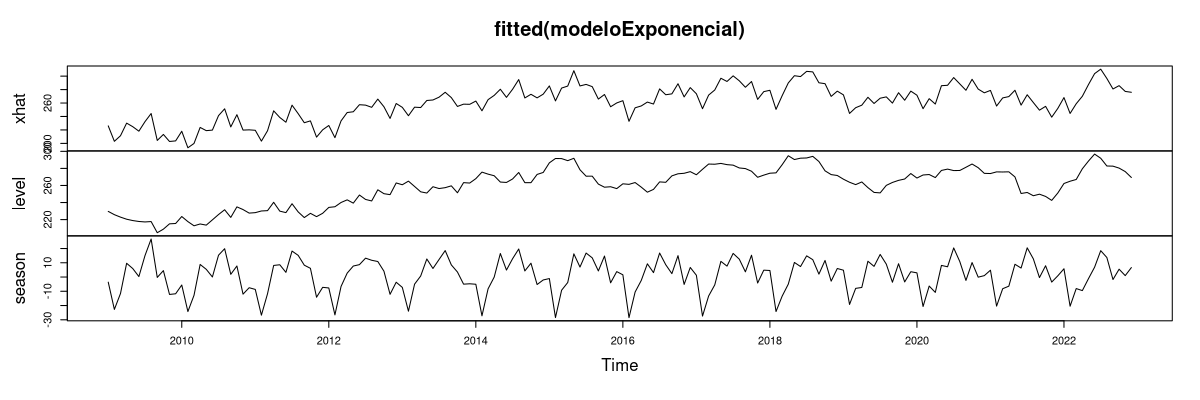

In [558]:
%%R  -w 12 -h 4 --units in -r 100
modeloExponencial = stats::HoltWinters(leche_train,
                                      beta = FALSE,
                                      seasonal = 'additive')
plot(fitted(modeloExponencial))

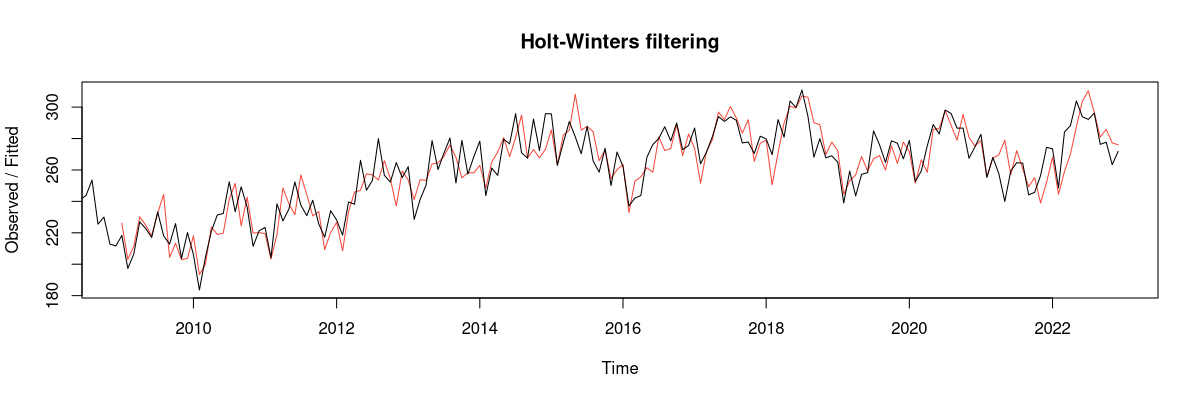

In [559]:
%%R  -w 12 -h 4 --units in -r 100
plot(modeloExponencial)

### **Agregando un factor de amotigüamiento ($\phi$)**

Note que entonces el modelo de suavizamiento exponencial que parece presentar un mejor comportamiento es aquel en que se ignora la tendencia y se agrega en el modelo solamente la estacionalidad de forma lineal. Sin embargo, sería prudente revisar la inclusión de un factor de amortigüamiento (damping) para revisar si así el modelo se comportaría mejor. Sin embargo, la función `stas::HoltWinters` no permite agregar este factor por lo que lo haremos con la función `forecast::hw()`

In [400]:
%%R
modeloExponencial = forecast::hw(leche_train,
                                 h = 12, # Generará predicciones un año adelante
                                damped = TRUE,
                                seasonal = 'additive')
cat(rep('=', 80),end = '\n', sep = '')
cat('Para el conjunto de prueba el MSE es: ', mean((modeloExponencial$mean - leche_test)**2), end = ' \n')
cat('Y para el conjunto de entrenamiento es: ', modeloExponencial$model[['mse']], '\n')
cat(rep('=', 80),end = '\n', sep = '')

Para el conjunto de prueba el MSE es:  201.5516  
Y para el conjunto de entrenamiento es:  99.07363 


In [401]:
%%R
modeloExponencial = forecast::hw(leche_train,
                                 h = 12, # Generará predicciones un año adelante
                                damped = TRUE,
                                seasonal = 'multiplicative')
cat(rep('=', 80),end = '\n', sep = '')
cat('Para el conjunto de prueba el MSE es: ', mean((modeloExponencial$mean - leche_test)**2), end = ' \n')
cat('Y para el conjunto de entrenamiento es: ', modeloExponencial$model[['mse']], '\n')
cat(rep('=', 80),end = '\n', sep = '')

Para el conjunto de prueba el MSE es:  191.7138  
Y para el conjunto de entrenamiento es:  100.2216 


Además de esto con esta función también es posible decidir si incluir la tendencia de forma exponencial o lineal con el argumento exponential:

In [405]:
%%R
modeloExponencial = forecast::hw(leche_train,
                                 h = 12, # Generará predicciones un año adelante
                                damped = TRUE,
                                seasonal = 'multiplicative',
                                exponential = TRUE)
cat(rep('=', 80),end = '\n', sep = '')
cat('Para el conjunto de prueba el MSE es: ', mean((modeloExponencial$mean - leche_test)**2), end = ' \n')
cat('Y para el conjunto de entrenamiento es: ', modeloExponencial$model[['mse']], '\n')
cat(rep('=', 80),end = '\n', sep = '')

Para el conjunto de prueba el MSE es:  205.7556  
Y para el conjunto de entrenamiento es:  99.68759 


### **Modelo final**

Teniendo en cuenta lo anterior, vemos que incluir un factor de aotigüamiento mejora el desempeño del modelo. Sin embargo, entre los tres modelos con este factor no hay diferencias tan notables por lo que se selecciona como representante del método de filtro exponencial al filtro con factor de amotigüamiento y de estacionalidad incluida de forma exponencial. Así:

In [456]:
%%R
modeloExponencial_leche = forecast::hw(leche_train,
                                 h = 12, # Generará predicciones dos años adelante
                                damped = TRUE,
                                seasonal = 'multiplicative')
summary(modeloExponencial_leche)


Forecast method: Damped Holt-Winters' multiplicative method

Model Information:
Damped Holt-Winters' multiplicative method 

Call:
 forecast::hw(y = leche_train, h = 12, seasonal = "multiplicative",  

 Call:
     damped = TRUE) 

  Smoothing parameters:
    alpha = 0.6062 
    beta  = 1e-04 
    gamma = 5e-04 
    phi   = 0.9799 

  Initial states:
    l = 236.5693 
    b = 0.0939 
    s = 0.9964 0.9638 1.0142 0.9958 1.0424 1.0604
           1.0254 1.0323 0.9816 0.9743 0.9105 1.003

  sigma:  0.0416

     AIC     AICc      BIC 
1805.401 1809.649 1862.874 

Error measures:
                   ME     RMSE      MAE         MPE     MAPE      MASE
Training set 0.295875 10.01107 7.929382 0.006586608 3.106075 0.4731381
                   ACF1
Training set -0.0425505

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2023       274.2006 259.5930 288.8083 251.8601 296.5412
Feb 2023       248.9051 233.3941 264.4160 225.1831 272.6270
Mar 2023       266.3639 247.6620 285.

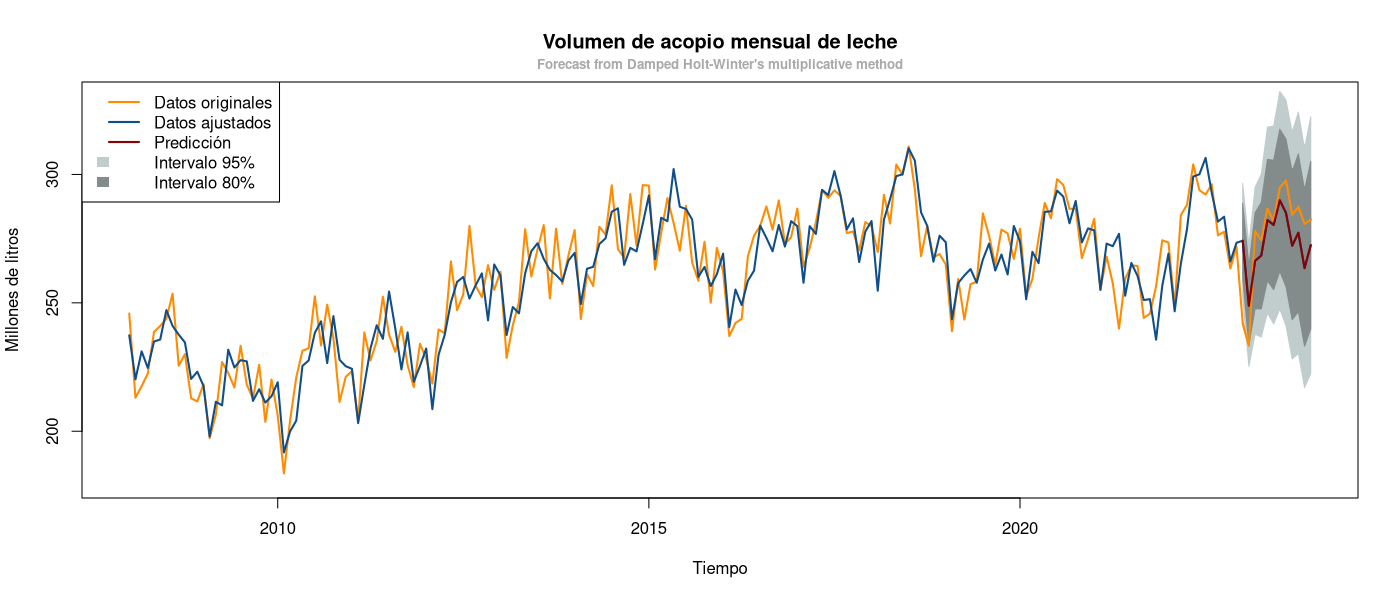

In [560]:
%%R -w 14 -h 6 --units in -r 100

# Gráfico principal (Serie original)
plot(leche, col = 'darkorange', main = 'Volumen de acopio mensual de leche', lwd = 2, ylim = c(180,330),
    ylab = 'Millones de litros', xlab = 'Tiempo')
mtext(bquote(bold('Forecast from Damped Holt-Winter\'s multiplicative method')),
      side = 3, line = 0.3, adj = 0.5, cex = 0.8, col = 'darkgray')

# Intervalos de confianza 95% (Datos de prueba)
polygon(x = c(time(leche_test), rev(time(leche_test))),
        y = c(modeloExponencial_leche$upper[,'95%'], rev(modeloExponencial_leche$lower[,'95%'])),
       col = 'azure3', border = 'azure3')

# Intervalos de confianza 85% (Datos de prueba)
polygon(x = c(time(leche_test), rev(time(leche_test))),
        y = c(modeloExponencial_leche$upper[,'80%'], rev(modeloExponencial_leche$lower[,'80%'])),
       col = 'azure4', border = 'azure4')

# Serie de datos ajustados (Filtro exponencial)
fitted_values = append(modeloExponencial_leche$fitted,modeloExponencial_leche$mean)
lines(x = time(leche), y = fitted_values, type = 'l', col = 'dodgerblue4', lwd = 2)

# Serie de datos de prueba
lines(leche_test, col = 'darkorange', lwd = 2)

# Serie datos de predicción (Filtro exponencial)
lines(modeloExponencial_leche$mean, type = 'l',col = 'darkred', lwd = 2)

# Leyenda
legend('topleft', legend = c('Datos originales', 'Datos ajustados', 'Predicción', 'Intervalo 95%', 'Intervalo 80%'),
       col = c('darkorange', 'dodgerblue4', 'darkred', 'azure3', 'azure4'), lty = c(1, 1, 1, NA, NA), lwd = c(2,2,2,NA,NA),
       fill = c(NA, NA, NA, 'azure3', 'azure4'), border = NA)

## **Precio del oro en Colombia (Frecuencia diaria) 🥇**